<a href="https://colab.research.google.com/github/VanderElton/Eye_Gaze/blob/main/Eye_gaze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

import h5py

from google.colab import files

from tqdm import tqdm
from tqdm import tqdm_notebook

from scipy.io import loadmat

from PIL import Image

import os


In [165]:
root_mpi_dir = '/content/MPIIGaze'
data_dir = '/content'
annot_dir = '/content/MPIIGaze/Annotation Subset'
img_dir = '/content/MPIIGaze/Original'

In [166]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [167]:
!kaggle datasets download "4quant/eye-gaze"
!unzip eye-gaze.zip

eye-gaze.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  eye-gaze.zip
replace MPIIGaze/6 points-based face model.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [168]:
def parse_mat(in_path):
    in_dat = loadmat(in_path, squeeze_me = True, struct_as_record = True)
    vec1_load, img_load,vec2_load = in_dat['data'].tolist()[1].tolist()
    return vec1_load, img_load, vec2_load
def mat_to_df(in_path):
    vec1_load, img_load, vec2_load = parse_mat(in_path)
    c_df = pd.DataFrame(dict(img=[x for x in img_load], 
                             vec1=[x for x in vec1_load],
                            vec2=[x for x in vec2_load]))
    c_df['group'] = os.path.basename(os.path.dirname(in_path))
    c_df['day'] = os.path.splitext(os.path.basename(in_path))[0]
    return c_df
def safe_mat_to_df(in_path):
    try:
        return mat_to_df(in_path)
    except ValueError as e:
        print('ValueError', e, in_path)
        return None
mat_files = glob.glob('/content/MPIIGaze/Data/Normalized/**/*.mat', recursive=True)
print(len(mat_files), 'normalized files found')

521 normalized files found


In [169]:
all_norm_df = pd.concat([safe_mat_to_df(in_path) for in_path in tqdm_notebook(mat_files)], ignore_index=True)
all_norm_df.sample(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/521 [00:00<?, ?it/s]

ValueError arrays must all be same length /content/MPIIGaze/Data/Normalized/p01/day39.mat
ValueError arrays must all be same length /content/MPIIGaze/Data/Normalized/p01/day69.mat


,img,vec1,vec2,group,day
39839,"[[87, 71, 61, 53, 42, 35, 31, 23, 21, 16, 11, ...","[-0.187229292571881, -0.006301796018651813, -0...","[-0.06933660585739623, -0.0492378413318248, -0...",p02,day32
206580,"[[126, 129, 129, 140, 146, 129, 146, 162, 162,...","[0.1653643011249263, 0.20822981624778075, -0.9...","[-0.05812106847349211, -0.017272833044559597, ...",p05,day08
194274,"[[40, 17, 17, 40, 40, 40, 40, 17, 40, 17, 17, ...","[0.07521511755867157, 0.255081402364891, -0.96...","[-0.020404325427951786, -0.33747381927795195, ...",p10,day15


No handles with labels found to put in legend.
No handles with labels found to put in legend.


213656 images loaded


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


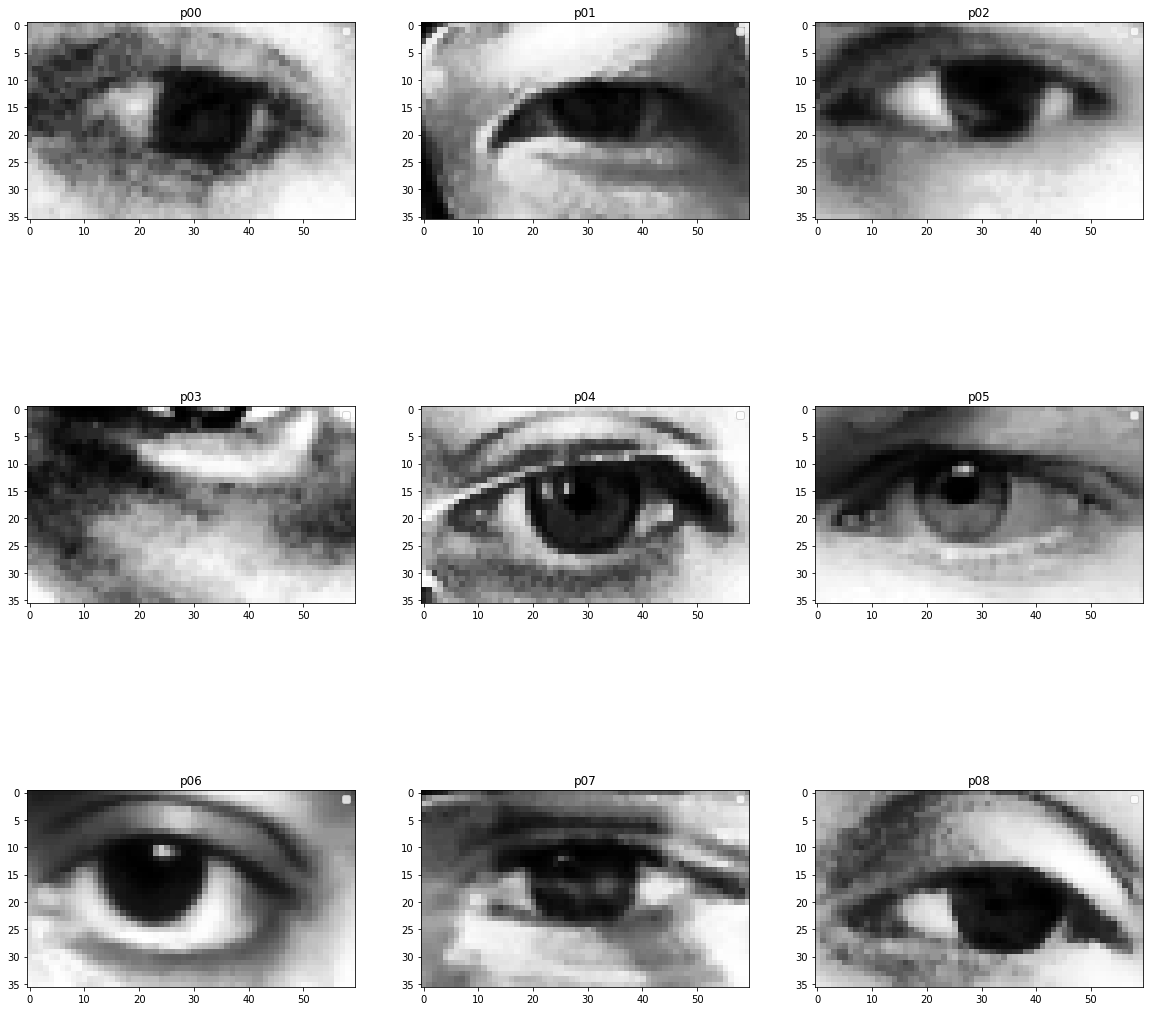

In [170]:
print(all_norm_df.shape[0], 'images loaded')
group_view = all_norm_df.groupby('group').apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, m_axs = plt.subplots(3, 3, figsize = (20, 20))
for (_, c_row), c_ax in zip(group_view.iterrows(), m_axs.flatten()):
    c_ax.imshow(c_row['img'], cmap = 'gray')
    c_ax.legend()
    c_ax.set_title('{group}'.format(**c_row))

In [171]:
for v in ['vec1', 'vec2']:
    for i, x_dim in enumerate('xyz'):
        all_norm_df['{}_{}'.format(v, x_dim)] = all_norm_df[v].map(lambda x: x[i])
all_norm_df.sample(3)

,img,vec1,vec2,group,day,vec1_x,vec1_y,vec1_z,vec2_x,vec2_y,vec2_z
13368,"[[79, 119, 125, 145, 152, 158, 158, 162, 149, ...","[-0.20228495887411121, 0.252695047493492, -0.9...","[-0.30416275496554573, -0.03963053642662494, -...",p01,day12,-0.202285,0.252695,-0.946164,-0.304163,-0.039631,-0.006075
114960,"[[64, 62, 62, 62, 66, 68, 68, 69, 68, 73, 77, ...","[-0.18857990840068287, 0.2943075555102888, -0....","[-0.3827469920349192, -0.09561154309278375, -0...",p03,day24,-0.188580,0.294308,-0.936921,-0.382747,-0.095612,-0.018539
4732,"[[25, 17, 16, 17, 12, 9, 6, 9, 6, 6, 0, 0, 0, ...","[0.031118757553505388, 0.2186311436119728, -0....","[-0.4275769526048331, -0.07129034261585047, -0...",p01,day43,0.031119,0.218631,-0.975311,-0.427577,-0.071290,-0.015485


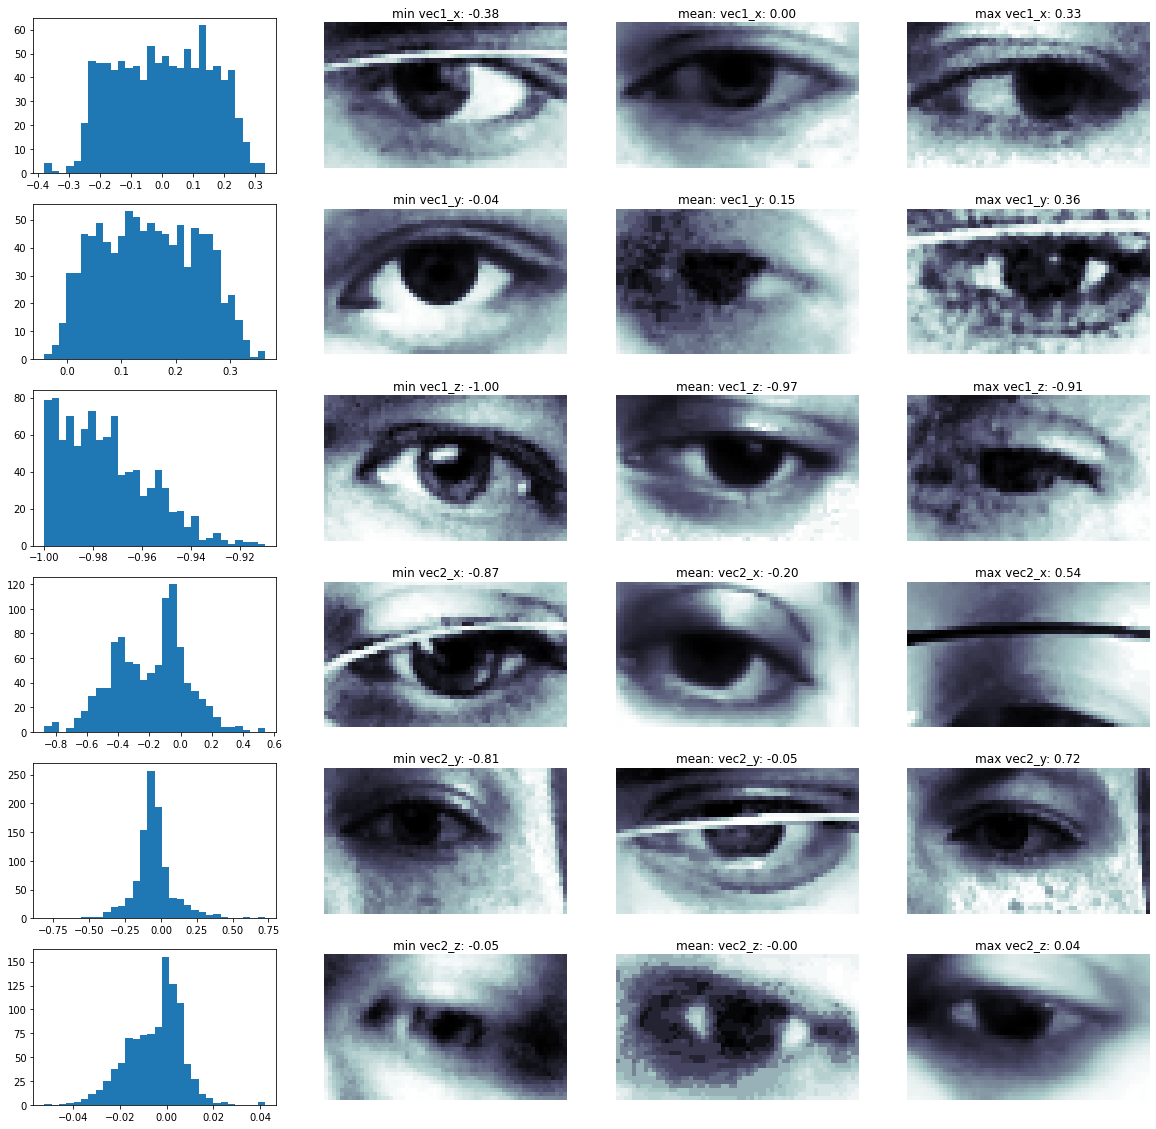

In [172]:
fig, m_axs = plt.subplots(6, 4, figsize = (20, 20))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
from itertools import product
for (ax_dist, ax_min, ax_mean, ax_max), (v, (i, x)) in zip(m_axs, product(['vec1', 'vec2'], enumerate('xyz'))):
    # use random sampling to get a better feeling
    c_vec = all_norm_df.sample(1000)['{}_{}'.format(v, x)]
    ax_dist.hist(c_vec.values, 30)
    ax_dist.axis('on')
    j = c_vec.idxmin()
    ax_min.imshow(all_norm_df.iloc[j]['img'], cmap = 'bone')
    ax_min.set_title('min {}_{}: {:2.2f}'.format(v, x, all_norm_df.iloc[j]['{}_{}'.format(v, x)]))
    
    k = c_vec.idxmax()
    ax_max.imshow(all_norm_df.iloc[k]['img'], cmap = 'bone')
    ax_max.set_title('max {}_{}: {:2.2f}'.format(v, x, all_norm_df.iloc[k]['{}_{}'.format(v, x)]))
    
    p = np.abs(c_vec-np.mean(c_vec)).idxmin()
    ax_mean.imshow(all_norm_df.iloc[p]['img'], cmap = 'bone')
    ax_mean.set_title('mean: {}_{}: {:2.2f}'.format(v, x, all_norm_df.iloc[p]['{}_{}'.format(v, x)]))

In [173]:
'''filename = "/content/gaze.h5"

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data = list(f[a_group_key])

#df = pd.read_csv('gaze.csv')
#print(df.shape)
#df.head()'''

'filename = "/content/gaze.h5"\n\nwith h5py.File(filename, "r") as f:\n    # List all groups\n    print("Keys: %s" % f.keys())\n    a_group_key = list(f.keys())[0]\n\n    # Get the data\n    data = list(f[a_group_key])\n\n#df = pd.read_csv(\'gaze.csv\')\n#print(df.shape)\n#df.head()'

In [174]:
'''def load_data(path):
    
    mat_files = glob.glob(f'{path}/**/*.mat', recursive=True)
    mat_files.sort()
    
    index = dict(left=list(), right=list())
    image = dict(left=list(), right=list())
    pose = dict(left=list(), right=list())
    gaze = dict(left=list(), right=list())
    #eyes = dict(left=list(), right=list())
    
    for file in tqdm(mat_files):
        # read file
        matfile = loadmat(file)
        
        # file name
        file_idx = file.split('/')[-2], file.split('/')[-1].split('.')[0]
        for eye in ['left', 'right']:
            index[eye].extend([[*file_idx, jpg[0][0], eye] for jpg in matfile['filenames']])
            #eyes[eye].extend([[eye] for jpg in matfile['filenames']])
            image[eye].extend(matfile['data'][eye][0, 0]['image'][0, 0])
            pose[eye].extend(matfile['data'][eye][0, 0]['pose'][0, 0])
            gaze[eye].extend(matfile['data'][eye][0, 0]['gaze'][0, 0])
    
    index = np.stack(tuple(index.values())).reshape((-1, 4))
    image = np.stack(tuple(image.values())).reshape((-1, 36, 60, 1))
    pose = np.stack(tuple(pose.values())).reshape((-1, 3))
    gaze = np.stack(tuple(gaze.values())).reshape((-1, 3))
    #eyes = np.stack(tuple(eyes.values())).reshape((-1, 1))
    return index, image, pose, gaze, eyes'''

"def load_data(path):\n    \n    mat_files = glob.glob(f'{path}/**/*.mat', recursive=True)\n    mat_files.sort()\n    \n    index = dict(left=list(), right=list())\n    image = dict(left=list(), right=list())\n    pose = dict(left=list(), right=list())\n    gaze = dict(left=list(), right=list())\n    #eyes = dict(left=list(), right=list())\n    \n    for file in tqdm(mat_files):\n        # read file\n        matfile = loadmat(file)\n        \n        # file name\n        file_idx = file.split('/')[-2], file.split('/')[-1].split('.')[0]\n        for eye in ['left', 'right']:\n            index[eye].extend([[*file_idx, jpg[0][0], eye] for jpg in matfile['filenames']])\n            #eyes[eye].extend([[eye] for jpg in matfile['filenames']])\n            image[eye].extend(matfile['data'][eye][0, 0]['image'][0, 0])\n            pose[eye].extend(matfile['data'][eye][0, 0]['pose'][0, 0])\n            gaze[eye].extend(matfile['data'][eye][0, 0]['gaze'][0, 0])\n    \n    index = np.stack(tuple(i

In [175]:
#mt = load_data('/content/MPIIGaze/Data/Normalized')

In [176]:
'''for i in mt:
print(mt[0][i])
print(mt[2][i])
print(mt[3][i])
print(mt[4][i])
#Image.fromarray(mt[1][i].reshape((36, 60)))
origPath = (f'/content/MPIIGaze/Data/Original/{mt[0][i][0]}/{mt[0][i][1]}/{mt[0][i][2]}')
img = Image.open(origPath)

img.show()'''

"for i in mt:\nprint(mt[0][i])\nprint(mt[2][i])\nprint(mt[3][i])\nprint(mt[4][i])\n#Image.fromarray(mt[1][i].reshape((36, 60)))\norigPath = (f'/content/MPIIGaze/Data/Original/{mt[0][i][0]}/{mt[0][i][1]}/{mt[0][i][2]}')\nimg = Image.open(origPath)\n\nimg.show()"